# **Upload Files**

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import pandas as pd
import glob

# folder path
data_path = "/content/drive/MyDrive/FL_IDS_Dataset/*.parquet"

# list all parquet files
files = glob.glob(data_path)
print("Files found:", len(files))
for f in files:
    print(f)

# load & merge all parquet files
df = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)

print("Final dataset shape:", df.shape)
df.head()


Files found: 8
/content/drive/MyDrive/FL_IDS_Dataset/Benign-Monday-no-metadata.parquet
/content/drive/MyDrive/FL_IDS_Dataset/Botnet-Friday-no-metadata.parquet
/content/drive/MyDrive/FL_IDS_Dataset/Bruteforce-Tuesday-no-metadata.parquet
/content/drive/MyDrive/FL_IDS_Dataset/DDoS-Friday-no-metadata.parquet
/content/drive/MyDrive/FL_IDS_Dataset/DoS-Wednesday-no-metadata.parquet
/content/drive/MyDrive/FL_IDS_Dataset/Infiltration-Thursday-no-metadata.parquet
/content/drive/MyDrive/FL_IDS_Dataset/Portscan-Friday-no-metadata.parquet
/content/drive/MyDrive/FL_IDS_Dataset/WebAttacks-Thursday-no-metadata.parquet
Final dataset shape: (2313810, 78)


,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,4,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,6,3,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,6,609,7,4,484,414,233,0,69.14286,111.967896,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


# **Install & Imports**

In [49]:
!pip -q install pyarrow

import os, glob, time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report,
    confusion_matrix, roc_auc_score, RocCurveDisplay
)

import matplotlib.pyplot as plt


# **GPU Check**

In [50]:
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Torch: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


device(type='cuda')

# **Load & Merge Dataset**

In [51]:
DATA_GLOB = "/content/drive/MyDrive/FL_IDS_Dataset/*.parquet"

files = sorted(glob.glob(DATA_GLOB))
print("Found files:", len(files))
for f in files:
    print(" -", os.path.basename(f))

df = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)
print("Merged shape:", df.shape)

# Sample for speed (increase later)
MAX_ROWS = 300_000
if len(df) > MAX_ROWS:
    df = df.sample(n=MAX_ROWS, random_state=42).reset_index(drop=True)

print("Using shape:", df.shape)
df.head(2)


Found files: 8
 - Benign-Monday-no-metadata.parquet
 - Botnet-Friday-no-metadata.parquet
 - Bruteforce-Tuesday-no-metadata.parquet
 - DDoS-Friday-no-metadata.parquet
 - DoS-Wednesday-no-metadata.parquet
 - Infiltration-Thursday-no-metadata.parquet
 - Portscan-Friday-no-metadata.parquet
 - WebAttacks-Thursday-no-metadata.parquet
Merged shape: (2313810, 78)
Using shape: (300000, 78)


,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,105357378,20,10,4030,3160,403,0,201.5,206.734634,...,32,2405830.0,400303.0625,2688887,2122773,50300000.0,51100000.0,86400000,14100000,Benign
1,6,183884,10,8,545,4196,188,0,54.5,69.984520,...,20,0.0,0.0000,0,0,0.0,0.0,0,0,Benign


# **Clean + Label Encoding**

In [52]:
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Normalize label text
df["Label_clean"] = df["Label"].astype(str).str.strip().str.upper()

# Binary IDS
df["y"] = (df["Label_clean"] != "BENIGN").astype(np.int64)

print(df["y"].value_counts())   # MUST show both 0 and 1


y
0    256152
1     43848
Name: count, dtype: int64


# **Features + Scaling**

In [53]:
X_df = df.drop(columns=["Label", "Label_clean", "y"], errors="ignore")
X_df = X_df.select_dtypes(include=[np.number])
y = df["y"].values

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df).astype(np.float32)
X_test  = scaler.transform(X_test_df).astype(np.float32)

y_train = y_train.astype(np.int64)
y_test  = y_test.astype(np.int64)

n_features = X_train.shape[1]

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train class counts:", np.bincount(y_train))


Train: (240000, 77) Test: (60000, 77)
Train class counts: [204922  35078]


# **Non-IID Client Split**

In [54]:
def non_iid_dirichlet_split(y, n_clients=8, alpha=0.2, seed=42):
    rng = np.random.default_rng(seed)
    client_indices = [[] for _ in range(n_clients)]
    classes = np.unique(y)

    for c in classes:
        idx = np.where(y == c)[0]
        rng.shuffle(idx)
        proportions = rng.dirichlet([alpha]*n_clients)
        cut = (np.cumsum(proportions)*len(idx)).astype(int)[:-1]
        splits = np.split(idx, cut)
        for i, s in enumerate(splits):
            client_indices[i].extend(s.tolist())

    for i in range(n_clients):
        rng.shuffle(client_indices[i])
    return client_indices

N_CLIENTS = 8
client_idxs = non_iid_dirichlet_split(y_train, N_CLIENTS, alpha=0.2)

for i in range(N_CLIENTS):
    vals, cnts = np.unique(y_train[client_idxs[i]], return_counts=True)
    print(f"Client {i}: {dict(zip(vals, cnts))}")


Client 0: {np.int64(0): np.int64(108190), np.int64(1): np.int64(7612)}
Client 1: {np.int64(0): np.int64(30210), np.int64(1): np.int64(7057)}
Client 2: {np.int64(0): np.int64(74), np.int64(1): np.int64(12173)}
Client 3: {np.int64(0): np.int64(27), np.int64(1): np.int64(778)}
Client 4: {np.int64(0): np.int64(463), np.int64(1): np.int64(2212)}
Client 5: {np.int64(0): np.int64(980), np.int64(1): np.int64(5236)}
Client 6: {np.int64(0): np.int64(62498), np.int64(1): np.int64(7)}
Client 7: {np.int64(0): np.int64(2480), np.int64(1): np.int64(3)}


# **Dataset & Loaders**

In [55]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx]

BATCH_SIZE = 512
pin = torch.cuda.is_available()

client_loaders, client_sizes = [], []
for i in range(N_CLIENTS):
    idxs = client_idxs[i]
    ds = TabularDataset(X_train[idxs], y_train[idxs])
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True,
                    num_workers=2, pin_memory=pin)
    client_loaders.append(dl)
    client_sizes.append(len(ds))

test_loader = DataLoader(
    TabularDataset(X_test, y_test),
    batch_size=2048, shuffle=False,
    num_workers=2, pin_memory=pin
)


# **Model**

In [56]:
class LightCNN_IDS(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.fc(self.net(x))


# **Training Helpers**

In [57]:
def train_one_epoch(model, loader, optimizer, criterion, clip_norm=5.0):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()
        total += loss.item()*len(yb)
    return total/len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    yp, yt = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        yp.append(torch.argmax(model(xb),1).cpu().numpy())
        yt.append(yb.numpy())
    y_true = np.concatenate(yt)
    y_pred = np.concatenate(yp)
    return {
        "acc": accuracy_score(y_true,y_pred),
        "precision": precision_score(y_true,y_pred,zero_division=0),
        "recall": recall_score(y_true,y_pred,zero_division=0),
        "f1": f1_score(y_true,y_pred,zero_division=0),
        "report": classification_report(y_true,y_pred,zero_division=0)
    }


# **Class Weights**

In [60]:
counts = np.bincount(y_train)
w0 = 1.0
w1 = counts[0]/counts[1]

criterion_weighted = nn.CrossEntropyLoss(
    weight=torch.tensor([w0, w1], device=device, dtype=torch.float32)
)
criterion_unweighted = nn.CrossEntropyLoss()

# **Centralized Baseline**

In [61]:
central_loader = DataLoader(
    TabularDataset(X_train,y_train),
    batch_size=512, shuffle=True
)

def train_centralized(criterion):
    model = LightCNN_IDS(n_features).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    for ep in range(3):
        loss = train_one_epoch(model, central_loader, opt, criterion)
        m = evaluate(model, test_loader)
        print(f"[Central Ep {ep+1}] acc={m['acc']:.4f} f1={m['f1']:.4f}")
    print(m["report"])
    return model

central_model = train_centralized(criterion_weighted)

[Central Ep 1] acc=0.9194 f1=0.7686
[Central Ep 2] acc=0.9230 f1=0.7801
[Central Ep 3] acc=0.8939 f1=0.7264
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     51230
           1       0.58      0.96      0.73      8770

    accuracy                           0.89     60000
   macro avg       0.79      0.92      0.83     60000
weighted avg       0.93      0.89      0.90     60000



# **Federated Learning (FedAvg & Robust)**

In [62]:
def get_params(m): return {k:v.cpu().clone() for k,v in m.state_dict().items()}
def set_params(m,p): m.load_state_dict(p)

def fedavg(ps, ws):
    out={}
    for k in ps[0]:
        out[k]=sum(w*p[k] for w,p in zip(ws,ps))
    return out

def trimmed_mean(ps, trim=0.1):
    out={}
    n=len(ps); k=int(n*trim)
    for key in ps[0]:
        s=torch.stack([p[key] for p in ps]).sort(0).values
        out[key]=s[k:n-k].mean(0)
    return out

def run_fl(criterion, robust=False):
    global_model = LightCNN_IDS(n_features).to(device)
    for r in range(10):
        params=[]; weights=[]
        gp=get_params(global_model)
        for i in range(N_CLIENTS):
            lm=LightCNN_IDS(n_features).to(device)
            set_params(lm,gp)
            opt=torch.optim.Adam(lm.parameters(),lr=1e-3)
            train_one_epoch(lm, client_loaders[i], opt, criterion)
            params.append(get_params(lm))
            weights.append(client_sizes[i])
        if robust:
            newp=trimmed_mean(params,0.1)
        else:
            w=np.array(weights)/sum(weights)
            newp=fedavg(params,w)
        set_params(global_model,newp)
        m=evaluate(global_model,test_loader)
        print(f"[FL {'Robust' if robust else 'FedAvg'} R{r+1}] acc={m['acc']:.4f} f1={m['f1']:.4f}")
    print(m["report"])
    return global_model


# **Run FL Experiments**

In [63]:
print("=== FL FedAvg (Weighted) ===")
fl_fedavg = run_fl(criterion_weighted, robust=False)

print("\n=== FL Robust TrimmedMean (Weighted, TRIM=0.1) ===")
fl_robust = run_fl(criterion_weighted, robust=True)


=== FL FedAvg (Weighted) ===
[FL FedAvg R1] acc=0.8538 f1=0.0011
[FL FedAvg R2] acc=0.9280 f1=0.6891
[FL FedAvg R3] acc=0.9500 f1=0.8087
[FL FedAvg R4] acc=0.9543 f1=0.8212
[FL FedAvg R5] acc=0.9463 f1=0.8025
[FL FedAvg R6] acc=0.9524 f1=0.8197
[FL FedAvg R7] acc=0.9616 f1=0.8650
[FL FedAvg R8] acc=0.9583 f1=0.8370
[FL FedAvg R9] acc=0.9577 f1=0.8359
[FL FedAvg R10] acc=0.9644 f1=0.8646
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     51230
           1       0.97      0.78      0.86      8770

    accuracy                           0.96     60000
   macro avg       0.97      0.89      0.92     60000
weighted avg       0.96      0.96      0.96     60000


=== FL Robust TrimmedMean (Weighted, TRIM=0.1) ===
[FL Robust R1] acc=0.1462 f1=0.2551
[FL Robust R2] acc=0.4802 f1=0.3427
[FL Robust R3] acc=0.4586 f1=0.3502
[FL Robust R4] acc=0.5161 f1=0.3762
[FL Robust R5] acc=0.5679 f1=0.4030
[FL Robust R6] acc=0.6459 f1=0.4485
[FL Robust R7] 

# **Probability prediction + Confusion Matrix + ROC-AUC**

In [66]:
@torch.no_grad()
def predict_proba(model, loader):
    model.eval()
    probs_all, y_all = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # P(attack)
        probs_all.append(probs)
        y_all.append(yb.numpy())
    return np.concatenate(probs_all), np.concatenate(y_all)

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.show()

def plot_roc(model, loader, title):
    probs, y_true = predict_proba(model, loader)
    auc = roc_auc_score(y_true, probs)
    RocCurveDisplay.from_predictions(y_true, probs)
    plt.title(title)
    plt.show()
    return auc

# **Evaluate Centralized + FL with Confusion + AUC**


==== Centralized (Weighted) ====
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     51230
           1       0.58      0.96      0.73      8770

    accuracy                           0.89     60000
   macro avg       0.79      0.92      0.83     60000
weighted avg       0.93      0.89      0.90     60000



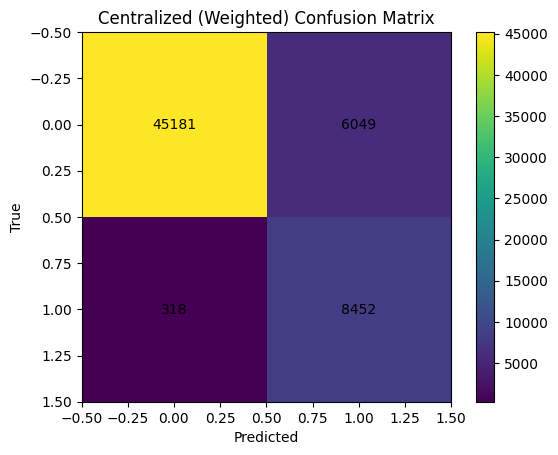

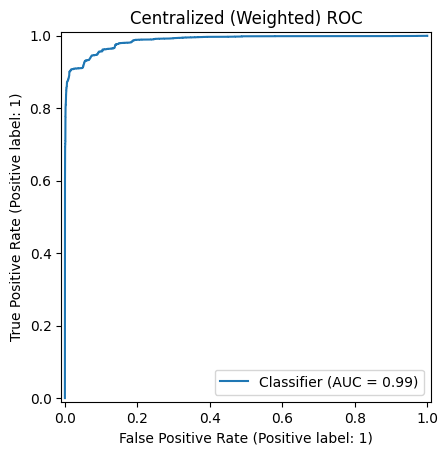

Centralized (Weighted) AUC: 0.9870130557943907

==== FL FedAvg (Weighted) ====
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     51230
           1       0.97      0.78      0.86      8770

    accuracy                           0.96     60000
   macro avg       0.97      0.89      0.92     60000
weighted avg       0.96      0.96      0.96     60000



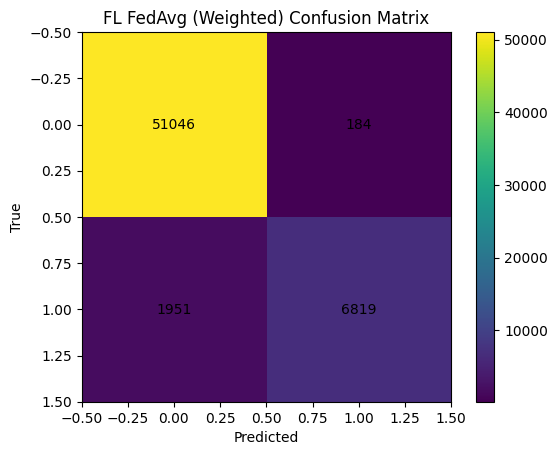

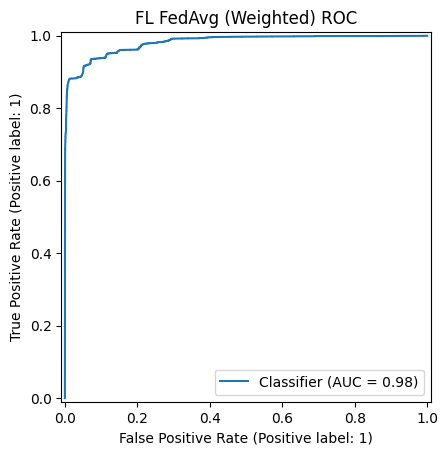

FL FedAvg (Weighted) AUC: 0.9817247779871712

==== FL Robust TrimmedMean (Weighted, TRIM=0.1) ====
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     51230
           1       0.47      0.95      0.63      8770

    accuracy                           0.83     60000
   macro avg       0.73      0.88      0.76     60000
weighted avg       0.91      0.83      0.85     60000



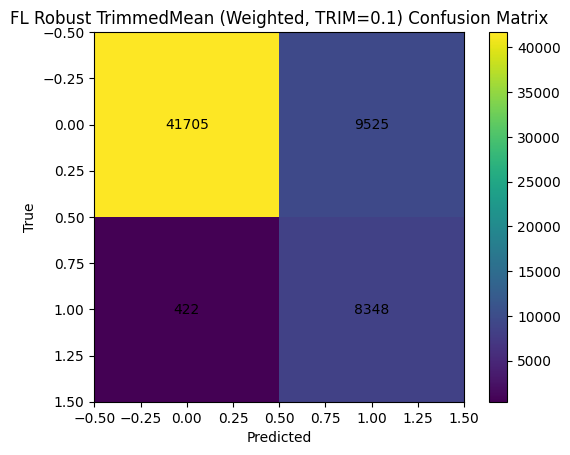

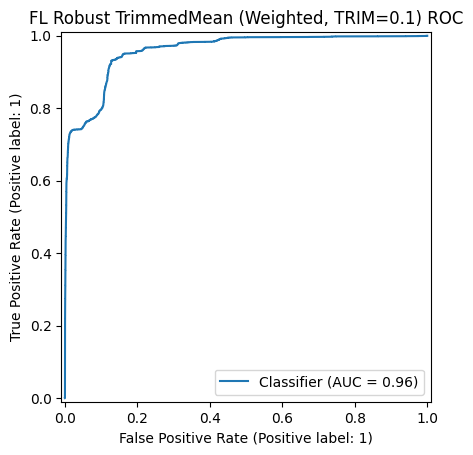

FL Robust TrimmedMean (Weighted, TRIM=0.1) AUC: 0.9587120206656278


In [67]:
def eval_full(model, loader, name):
    probs, y_true = predict_proba(model, loader)
    y_pred = (probs >= 0.5).astype(int)

    print(f"\n==== {name} ====")
    print(classification_report(y_true, y_pred, zero_division=0))

    plot_confusion(y_true, y_pred, f"{name} Confusion Matrix")
    auc = plot_roc(model, loader, f"{name} ROC")
    print(f"{name} AUC:", auc)

# Centralized
eval_full(central_model, test_loader, "Centralized (Weighted)")

# FL FedAvg
eval_full(fl_fedavg, test_loader, "FL FedAvg (Weighted)")

# FL Robust
eval_full(fl_robust, test_loader, "FL Robust TrimmedMean (Weighted, TRIM=0.1)")

# **Record Round-wise History (for IEEE plots)**

In [68]:
def run_fl_with_history(criterion, robust=False, rounds=10, trim=0.1, lr=1e-3):
    global_model = LightCNN_IDS(n_features).to(device)
    history = []

    for r in range(1, rounds+1):
        params=[]; weights=[]
        gp=get_params(global_model)

        for i in range(N_CLIENTS):
            lm=LightCNN_IDS(n_features).to(device)
            set_params(lm,gp)
            opt=torch.optim.Adam(lm.parameters(),lr=lr)
            train_one_epoch(lm, client_loaders[i], opt, criterion)
            params.append(get_params(lm))
            weights.append(client_sizes[i])

        if robust:
            newp=trimmed_mean(params, trim)
        else:
            w=np.array(weights)/sum(weights)
            newp=fedavg(params,w)

        set_params(global_model,newp)

        m=evaluate(global_model,test_loader)
        history.append((r, m["acc"], m["f1"]))
        print(f"[FL {'Robust' if robust else 'FedAvg'} R{r}] acc={m['acc']:.4f} f1={m['f1']:.4f}")

    print("\nFinal report:\n", evaluate(global_model,test_loader)["report"])
    return global_model, history


# **Get histories**

In [69]:
fl_fedavg2, hist_fedavg = run_fl_with_history(criterion_weighted, robust=False, rounds=10)
fl_robust2, hist_robust = run_fl_with_history(criterion_weighted, robust=True, rounds=10, trim=0.1)


[FL FedAvg R1] acc=0.8538 f1=0.0000
[FL FedAvg R2] acc=0.9325 f1=0.7160
[FL FedAvg R3] acc=0.9395 f1=0.7456
[FL FedAvg R4] acc=0.9554 f1=0.8250
[FL FedAvg R5] acc=0.9556 f1=0.8242
[FL FedAvg R6] acc=0.9511 f1=0.8145
[FL FedAvg R7] acc=0.9521 f1=0.8178
[FL FedAvg R8] acc=0.9578 f1=0.8332
[FL FedAvg R9] acc=0.9672 f1=0.8767
[FL FedAvg R10] acc=0.9683 f1=0.8833

Final report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     51230
           1       0.96      0.82      0.88      8770

    accuracy                           0.97     60000
   macro avg       0.96      0.91      0.93     60000
weighted avg       0.97      0.97      0.97     60000

[FL Robust R1] acc=0.8914 f1=0.6682
[FL Robust R2] acc=0.7637 f1=0.4865
[FL Robust R3] acc=0.5979 f1=0.4163
[FL Robust R4] acc=0.4418 f1=0.3437
[FL Robust R5] acc=0.5551 f1=0.3962
[FL Robust R6] acc=0.6775 f1=0.4709
[FL Robust R7] acc=0.7737 f1=0.5542
[FL Robust R8] acc=0.7714 f1=0.5536
[FL Robu

# **Plot Accuracy/F1 vs Rounds (IEEE figure)**

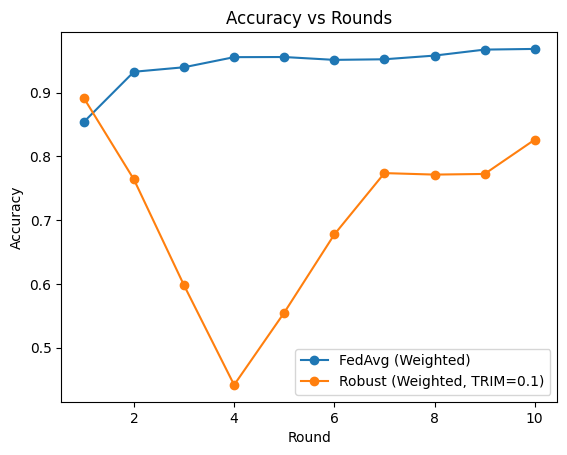

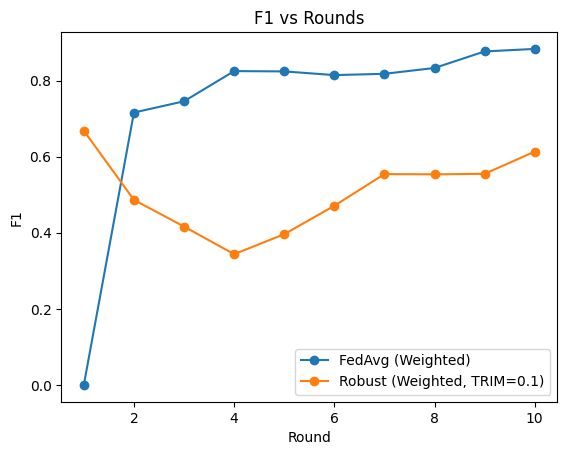

In [70]:
def plot_histories(h1, h2, label1="FedAvg", label2="Robust"):
    r1 = [x[0] for x in h1]; acc1 = [x[1] for x in h1]; f11 = [x[2] for x in h1]
    r2 = [x[0] for x in h2]; acc2 = [x[1] for x in h2]; f12 = [x[2] for x in h2]

    plt.figure()
    plt.plot(r1, acc1, marker="o", label=label1)
    plt.plot(r2, acc2, marker="o", label=label2)
    plt.xlabel("Round"); plt.ylabel("Accuracy"); plt.title("Accuracy vs Rounds")
    plt.legend(); plt.show()

    plt.figure()
    plt.plot(r1, f11, marker="o", label=label1)
    plt.plot(r2, f12, marker="o", label=label2)
    plt.xlabel("Round"); plt.ylabel("F1"); plt.title("F1 vs Rounds")
    plt.legend(); plt.show()

plot_histories(hist_fedavg, hist_robust, "FedAvg (Weighted)", "Robust (Weighted, TRIM=0.1)")


# **Poisoning Experiment (Robustness Proof)**

In [71]:
def poison_params(params, scale=-2.0):
    # milder sign-flip/scaling
    return {k: v * scale for k, v in params.items()}

def run_fl_poisoning(criterion, robust=False, rounds=10, trim=0.1, lr=1e-3, malicious_frac=0.25, seed=42):
    np.random.seed(seed)
    global_model = LightCNN_IDS(n_features).to(device)
    history = []

    mal_k = max(1, int(N_CLIENTS * malicious_frac))
    malicious_clients = set(np.random.choice(np.arange(N_CLIENTS), size=mal_k, replace=False))
    print("Malicious clients:", malicious_clients)

    for r in range(1, rounds+1):
        params=[]; weights=[]
        gp=get_params(global_model)

        for i in range(N_CLIENTS):
            lm=LightCNN_IDS(n_features).to(device)
            set_params(lm,gp)
            opt=torch.optim.Adam(lm.parameters(),lr=lr)
            train_one_epoch(lm, client_loaders[i], opt, criterion)
            p=get_params(lm)

            if i in malicious_clients:
                p = poison_params(p, scale=-2.0)

            params.append(p)
            weights.append(client_sizes[i])

        if robust:
            newp=trimmed_mean(params, trim)
        else:
            w=np.array(weights)/sum(weights)
            newp=fedavg(params,w)

        set_params(global_model,newp)
        m=evaluate(global_model,test_loader)
        history.append((r, m["acc"], m["f1"]))
        print(f"[Poison {'Robust' if robust else 'FedAvg'} R{r}] acc={m['acc']:.4f} f1={m['f1']:.4f}")

    return global_model, history


# **Run poisoning**

Malicious clients: {np.int64(1), np.int64(5)}
[Poison FedAvg R1] acc=0.8538 f1=0.0000
[Poison FedAvg R2] acc=0.8538 f1=0.0000
[Poison FedAvg R3] acc=0.8538 f1=0.0000
[Poison FedAvg R4] acc=0.8538 f1=0.0000
[Poison FedAvg R5] acc=0.8538 f1=0.0000
[Poison FedAvg R6] acc=0.8538 f1=0.0000
[Poison FedAvg R7] acc=0.8538 f1=0.0000
[Poison FedAvg R8] acc=0.8538 f1=0.0000
[Poison FedAvg R9] acc=0.8538 f1=0.0000
[Poison FedAvg R10] acc=0.8538 f1=0.0000
Malicious clients: {np.int64(1), np.int64(5)}
[Poison Robust R1] acc=0.8270 f1=0.1310
[Poison Robust R2] acc=0.8538 f1=0.0000
[Poison Robust R3] acc=0.8538 f1=0.0000
[Poison Robust R4] acc=0.8538 f1=0.0000
[Poison Robust R5] acc=0.8538 f1=0.0000
[Poison Robust R6] acc=0.8538 f1=0.0000
[Poison Robust R7] acc=0.8538 f1=0.0000
[Poison Robust R8] acc=0.8538 f1=0.0000
[Poison Robust R9] acc=0.8538 f1=0.0000
[Poison Robust R10] acc=0.8538 f1=0.0000


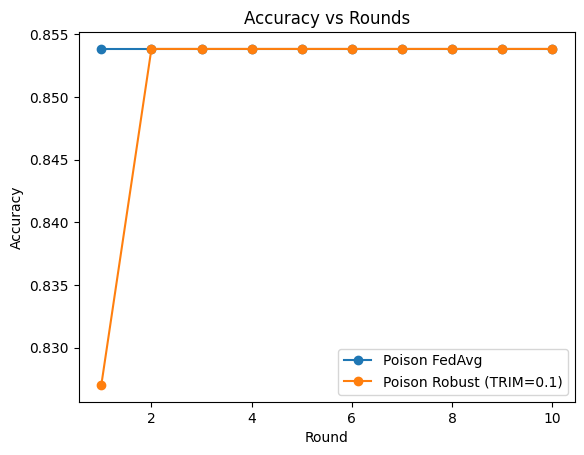

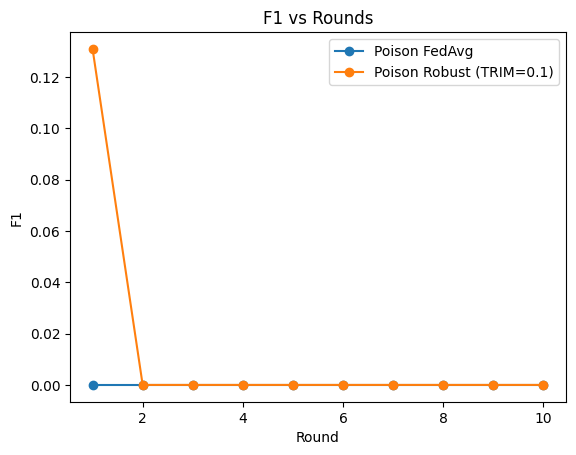

In [72]:
poison_fedavg, hist_poison_fedavg = run_fl_poisoning(criterion_weighted, robust=False, rounds=10, malicious_frac=0.25)
poison_robust, hist_poison_robust = run_fl_poisoning(criterion_weighted, robust=True, rounds=10, trim=0.1, malicious_frac=0.25)

plot_histories(hist_poison_fedavg, hist_poison_robust, "Poison FedAvg", "Poison Robust (TRIM=0.1)")


# **Save Models + Scaler (Reproducibility)**

In [73]:
import joblib

torch.save(central_model.state_dict(), "/content/central_weighted.pth")
torch.save(fl_fedavg.state_dict(), "/content/fl_fedavg_weighted.pth")
torch.save(fl_robust.state_dict(), "/content/fl_robust_trim01_weighted.pth")

joblib.dump(scaler, "/content/standard_scaler.pkl")

print("Saved models + scaler to /content/")


Saved models + scaler to /content/


# **Communication Cost Estimate (Nice IEEE Table Item)**

In [74]:
def model_size_bytes(model):
    total = 0
    for p in model.parameters():
        total += p.numel() * p.element_size()
    return total

size_b = model_size_bytes(fl_fedavg)
size_mb = size_b / (1024**2)
print(f"Model size: {size_mb:.3f} MB")

ROUNDS = 10
N_CLIENTS = 8

# Rough uplink per round: each client sends model once
uplink_mb = ROUNDS * N_CLIENTS * size_mb
downlink_mb = ROUNDS * size_mb  # server broadcasts one global model per round (per client depends; keep simple)

print(f"Approx uplink (clients→server): {uplink_mb:.2f} MB over {ROUNDS} rounds")
print(f"Approx server broadcast (server→clients): {downlink_mb:.2f} MB over {ROUNDS} rounds (per client would be x N_CLIENTS)")


Model size: 0.057 MB
Approx uplink (clients→server): 4.54 MB over 10 rounds
Approx server broadcast (server→clients): 0.57 MB over 10 rounds (per client would be x N_CLIENTS)
